In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.60.149:34919")
client

Client Scheduler: tcp://10.32.60.149:34919 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 5 Cores: 10 Memory: 57.50 GB


# SOSE POTENTIAL DENSITY BUDGET

In [2]:
import os

os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

import xarray as xr
import numpy as np
import dask as dask
from matplotlib import pyplot as plt
%matplotlib inline
import intake
import pandas as pd
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
import gsw

In [3]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds_raw_coords = ocean_cat["SOSE"].to_dask()
ds_raw_coords

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [4]:
coords = ds_raw_coords.coords.to_dataset().reset_coords() #ds split into coords
ds = ds_raw_coords.reset_coords(drop=True) #ds dropping coords so it just holds data variables
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

## Compute density flux
(units of $\frac{kg}{m^{2}s}$)
$$
F_{\sigma} = F_{heat}\frac{\partial\sigma}{\partial\theta} + F_{salt}\frac{\partial\sigma}{\partial S}\
$$

$$
\alpha = - \frac{1}{\rho_{0}c^{0}_{p}} \frac{\partial\rho}{\partial \theta}
$$

$$
\beta = \frac{1}{\rho_{0}} \frac{\partial\rho}{\partial S}
$$

In [5]:
sst = ds.THETA.isel(Z=0)
sss = ds.SALT.isel(Z=0)

In [6]:
#converting practical salinity to absolute salinity
sa = xr.apply_ufunc(gsw.SA_from_SP, sss, 0, ds.XC, ds.YC,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [7]:
#converting potential temperature to conservative temperature
ct = xr.apply_ufunc(gsw.CT_from_pt, sa, sst,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [8]:
runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg

### Thermal expansion coefficient @ surface

In [9]:
#thermal expansion coefficient @ surface
alpha_0 = xr.apply_ufunc(gsw.alpha, sa, ct, 0,
                    output_dtypes=[sst.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_0

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

### Haline contraction coefficient @ surface

In [10]:
#haline contraction coefficient @ surface
beta_0 = xr.apply_ufunc(gsw.beta, sa, ct, 0,
                      output_dtypes=[sss.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_0

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

## Temperature component of sigma flux at surface

$$
\frac{\partial}{\partial{\sigma}} \int{F_{\sigma_{heat}}} dV = \frac{\partial{\sigma}}{\partial{\theta}} \frac{\dot{\theta}}{\sigma} = \alpha \dot{\theta}
$$

In [11]:
sst_mean = ds.THETA.isel(Z=0).mean(dim='time')#.load()

In [12]:
surface_mask = (coords.hFacC[0]>0)#.load()

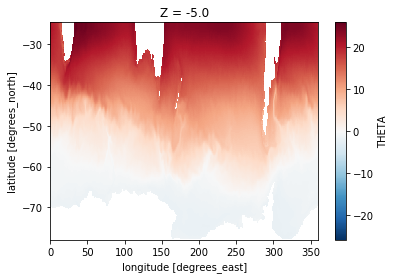

In [13]:
sst_mean.where(surface_mask).plot()

In [14]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat = -78

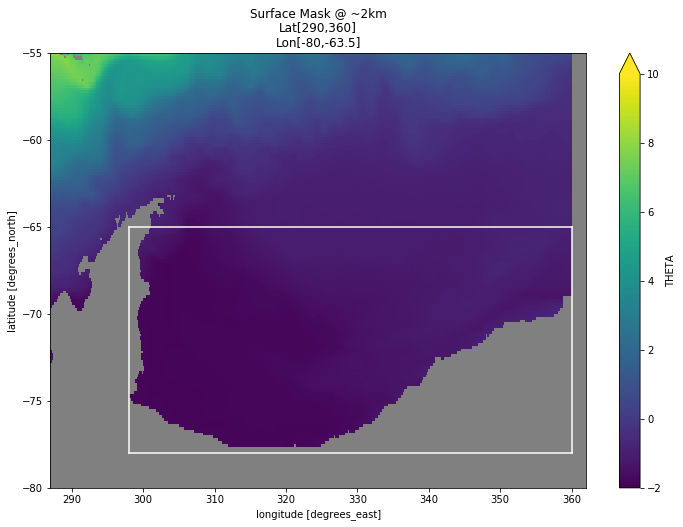

In [15]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [16]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [17]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [18]:
#advective flux
adv_flux_y = ds.ADVy_TH.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
adv_flux_x = ds.ADVx_TH.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-13177336., -13868049., -15939710., ..., -13312121.,  -9721594.,
       -11875297.], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [19]:
#diffusive flux
diff_flux_y = ds.DFyE_TH.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
diff_flux_x = ds.DFxE_TH.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ -7738.631 , -13908.878 ,  -6383.6543, ...,  37860.953 ,  43654.906 ,
        30965.42  ], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [20]:
#vertical flux
t_flux_z = (ds.TFLUX.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z#.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
dask.array<shape=(438,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [21]:
#linear free surface correction
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(ds.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).isel(**lat_range, **lon_range).sum(dim=['XC', 'YC'])
#units: (˚C m^3)/s

In [22]:
surface_term

<xarray.DataArray (time: 438)>
dask.array<shape=(438,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [23]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([-5951370.5 ,   511134.2 ,  -564776.1 , ...,  -875860.25,  -550849.06,
        -347501.28], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [24]:
tottend_weddell = (ds.TOTTTEND * coords.rA * coords.drF * coords.hFacC).isel(
                                                   **lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([20346913.374815, 29569858.37037 , 36194607.407407, ..., 22317180.397037,
       21744615.727407, 32467708.586667])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

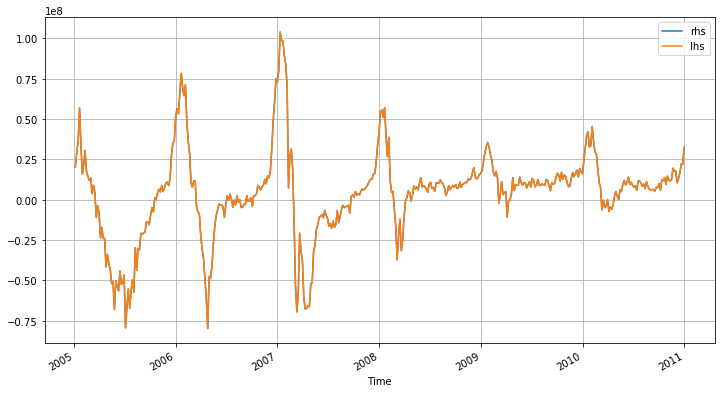

In [25]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

In [26]:
rhs

<xarray.DataArray (time: 438)>
array([20346918., 29569856., 36194600., ..., 22317180., 21744612., 32467720.],
      dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [27]:
alpha_surf = (alpha_0.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC']).load()
alpha_surf

<xarray.DataArray (time: 438)>
array([42888348., 46359970., 47986596., ..., 18193036., 19408868., 21885428.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [28]:
F_sig_heat = (alpha_surf * rhs) #/ heat_capacity_cp
F_sig_heat.load() #kg/m^2/s

<xarray.DataArray (time: 438)>
array([8.726457e+14, 1.370858e+15, 1.736856e+15, ..., 4.060173e+14,
       4.220383e+14, 7.105699e+14], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 359.83334
    YG       float32 -64.9583

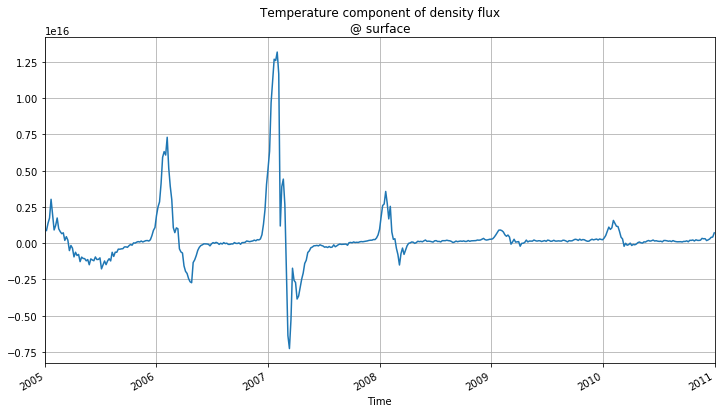

In [110]:
F_sig_heat.plot(figsize=(12,6))
plt.xlim('2005', '2011')
plt.grid()
plt.title('Temperature component of density flux\n@ surface');

## Salinity component of sigma flux at surface

$$
F_{\sigma_{salt}} = \frac{\partial{\sigma}}{\partial{S}}\dot{S} = \beta \frac{(E-P-R)}{\rho_{fw}} = \beta\dot{S}
$$

In [30]:
sss_mean = ds.SALT.isel(Z=0).mean(dim='time').load()

In [31]:
surface_mask = (coords.hFacC[0]>0).load()

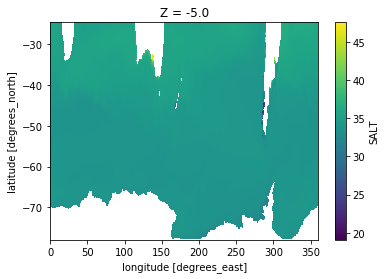

In [32]:
sss_mean.where(surface_mask).plot()

In [33]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat = -78

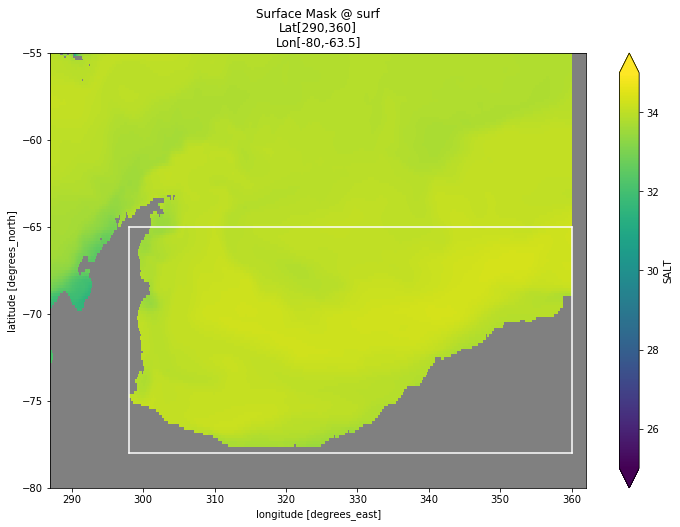

In [34]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})

(sss_mean.where(surface_mask)).plot(ax=ax, vmin=25, vmax=35)

ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')

ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ surf\nLat[290,360]\nLon[-80,-63.5]');

In [35]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [36]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [37]:
#advective flux
adv_flux_y = ds.ADVy_SLT.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
adv_flux_x = ds.ADVx_SLT.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ 2.447882e+08, -3.040422e+07, -3.342464e+06, ...,  1.534080e+07,
        1.029645e+07,  9.591744e+06], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [38]:
#diffusive flux
diff_flux_y = ds.DFyE_SLT.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
diff_flux_x = ds.DFxE_SLT.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([11423.828 , 13190.536 , 12715.232 , ...,  7903.9834,  9183.003 ,
        6305.7637], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [39]:
#vertical flux
s_flux_z = (ds.SFLUX.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
s_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([-1.509145e+10, -6.025610e+09, -3.705961e+09, ..., -6.701154e+09,
       -1.019930e+10, -9.377601e+09], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [40]:
#linear free surface correction
runit2mass = 1.035e3 #kg/m^3
surface_term = s_flux_z / runit2mass
#units: (˚C m^3)/s

lin_fs_correction = -(ds.WSLTMASS.isel(Zl=0, drop=True) * coords.rA
                     ).isel(**lat_range, **lon_range).sum(dim=['XC', 'YC'])
#i noticed lin_fs_corr term didn't have `**lon_range` - should it not have?
#units: (˚C m^3)/s

In [41]:
surface_term.load()

<xarray.DataArray (time: 438)>
array([-14581116. ,  -5821845.5,  -3580639. , ...,  -6474544.5,  -9854398. ,
        -9060484. ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [42]:
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([ 2.375502e+08, -2.544512e+07, -3.069500e+06, ...,  1.647154e+07,
        1.047929e+07,  9.101356e+06], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [43]:
totstend_weddell = (ds.TOTSTEND * coords.rA * coords.drF * coords.hFacC).isel(
                            **lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
totstend_weddell.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-21830561.943704,   -875868.539259,  -3320426.571852, ...,
        -5351765.712593,  -9680683.614815,  -9557159.632593])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

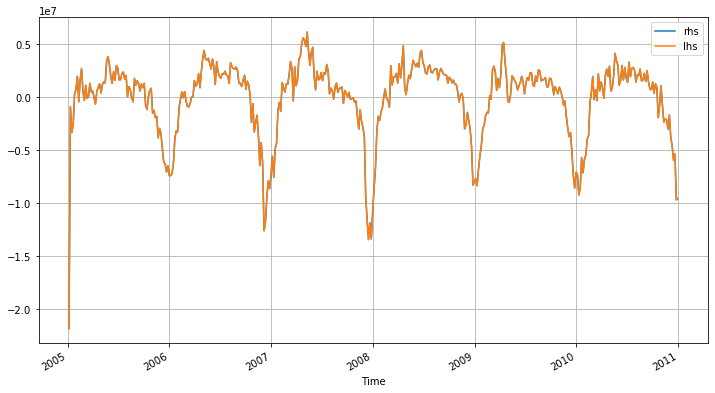

In [44]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = totstend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

In [45]:
beta_surf = (beta_0.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC']).load()
beta_surf

<xarray.DataArray (time: 438)>
array([2.495490e+09, 2.494732e+09, 2.494383e+09, ..., 2.501398e+09,
       2.501089e+09, 2.500475e+09], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [46]:
F_sig_salt = beta_surf * rhs
F_sig_salt.load() #kg/m^2/s

<xarray.DataArray (time: 438)>
array([-5.447794e+16, -2.185209e+15, -8.282324e+15, ..., -1.338674e+16,
       -2.421239e+16, -2.389748e+16], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 359.83334
    YG       float32 -64.9583

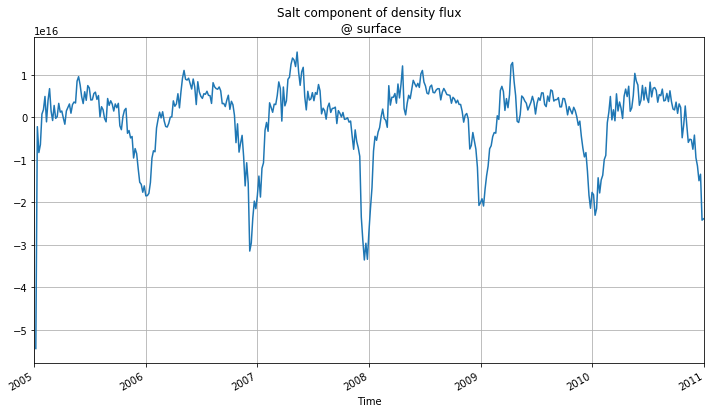

In [111]:
F_sig_salt.plot(figsize=(12,6))
plt.xlim('2005', '2011')
plt.grid()
plt.title('Salt component of density flux\n @ surface');

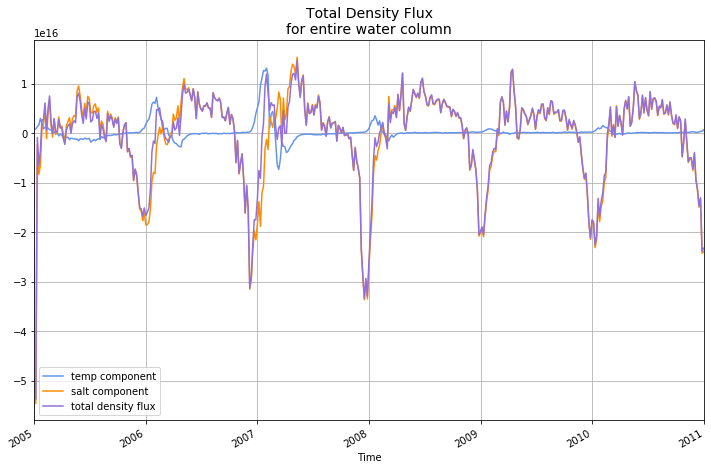

In [84]:
plt.figure(figsize=(12,7))
F_sig_heat.plot(label='temp component', c='cornflowerblue')
F_sig_salt.plot(label='salt component', c='darkorange')
(F_sig_heat + F_sig_salt).plot(label='total density flux', c='mediumpurple')
plt.xlim('2005', '2011')
plt.grid()
plt.legend()
plt.title('Total Density Flux\nfor entire water column', fontsize=14, weight='medium');

# Lower 3km

In [87]:
sst_lower = ds.THETA.isel(Z=27)
sss_lower = ds.SALT.isel(Z=27)

In [88]:
#converting practical salinity to absolute salinity
sa_lower = xr.apply_ufunc(gsw.SA_from_SP, sss_lower, 27, ds.XC, ds.YC,
                    output_dtypes=[sss_lower.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_lower

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [89]:
#converting potential temperature to conservative temperature
ct_lower = xr.apply_ufunc(gsw.CT_from_pt, sa_lower, sst_lower,
                    output_dtypes=[sss_lower.dtype],
                    dask='parallelized').reset_coords(drop=True)
ct_lower

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

### Thermal expansion coefficient @ 2,046m

In [90]:
#thermal expansion coefficient @ 2,046m
alpha_lower = xr.apply_ufunc(gsw.alpha, sa_lower, ct_lower, 27,
                    output_dtypes=[sst_lower.dtype],
                    dask='parallelized').reset_coords(drop=True)
alpha_lower

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

### Haline contraction coefficient @ 2,046m

In [91]:
#haline contraction coefficient @ 2,046m
beta_lower = xr.apply_ufunc(gsw.beta, sa_lower, ct_lower, 27,
                      output_dtypes=[sss_lower.dtype],
                      dask='parallelized').reset_coords(drop=True)
beta_lower

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

## Temperature component of sigma flux at 2,046m

In [92]:
sst_mean_lower = sst_lower.mean(dim='time').load()

In [93]:
surface_mask_lower = (coords.hFacC.isel(Z=27)>0).load()

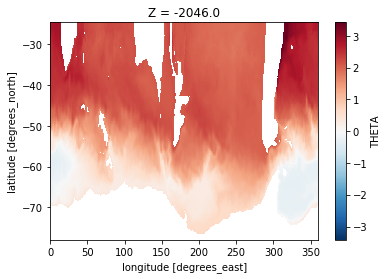

In [94]:
sst_mean_lower.where(surface_mask_lower).plot()

In [95]:
left_lon = 299
upper_lat = -66
right_lon = 360
lower_lat = -78

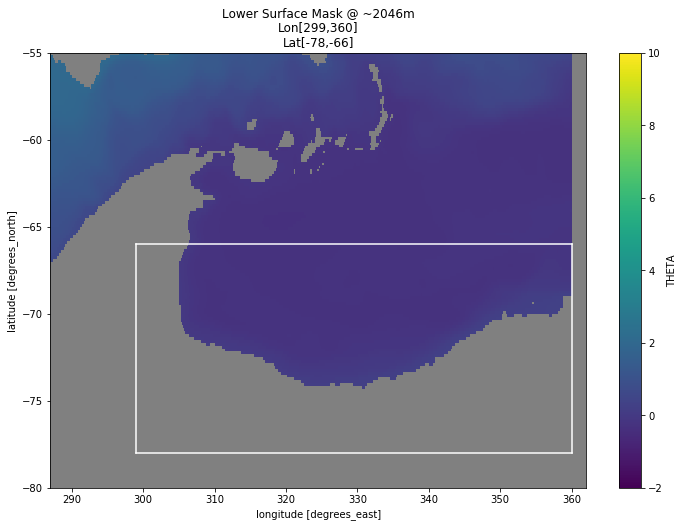

In [96]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean_lower.where(surface_mask_lower)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Lower Surface Mask @ ~2046m\nLon[299,360]\nLat[-78,-66]');

In [97]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [98]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [99]:
#advective flux
adv_flux_y_lower = ds.ADVy_TH.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['XC','Z']).load()
adv_flux_x_lower = ds.ADVx_TH.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['YC','Z']).load()
adv_flux_z_lower = ds.ADVr_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-2421230.5 ,  -529339.4 , -2847650.8 , ..., -1889367.1 ,  -214636.23,
       -2014028.  ], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -66.12497
    Zl       float32 -1904.0

In [100]:
#diffusive flux
diff_flux_y_lower = ds.DFyE_TH.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                dim=['XC','Z']).load()
diff_flux_x_lower = ds.DFxE_TH.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                dim=['YC','Z']).load()
diff_flux_z_lower =  ((ds.DFrE_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + ds.DFrI_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + ds.KPPg_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                                                                                                 ).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-2.093874e+07,  1.319831e+04,  1.194280e+04, ...,  7.516209e+03,
        1.212570e+04,  1.274360e+04], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -66.12497
    Zl       float32 -1904.0

In [101]:
tottend_weddell_lower = ((ds.TOTTTEND * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                    dim=['XC', 'YC','Z'])) / (24*60*60)
tottend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([23359968.900741,   516140.942222,  2835707.828148, ...,  1881851.06963 ,
         202510.672593,  2001284.551111])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

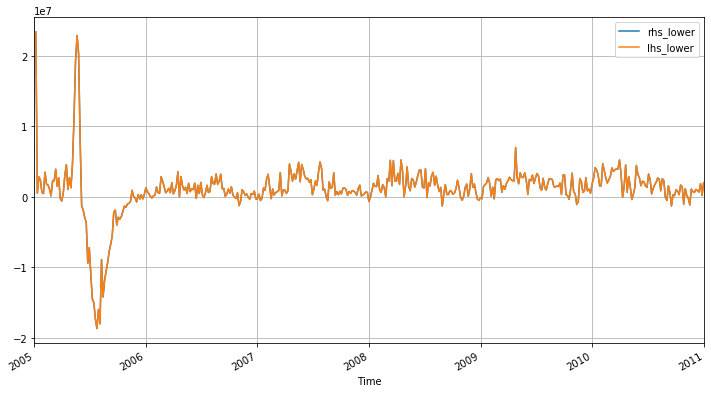

In [106]:
plt.figure(figsize=(12,6))
rhs_lower = - adv_flux_lower - diff_flux_lower
lhs_lower = tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.xlim('2005', '2011')
plt.grid();

In [103]:
alpha_bottom = (alpha_lower.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC']).load()
alpha_bottom

<xarray.DataArray (time: 438)>
array([ 539432.,  541252.,  543884., ..., 2140922., 2149476., 2158804.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [104]:
F_sig_heat_lower = (alpha_bottom * rhs_lower) #/ heat_capacity_cp
F_sig_heat_lower.load() #kg/m^2/s

<xarray.DataArray (time: 438)>
array([1.260111e+13, 2.793624e+11, 1.542296e+12, ..., 4.028896e+12,
       4.352915e+11, 4.320381e+12], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 359.83334
    YG       float32 -66.12497
    Zl       float32 -1904.0

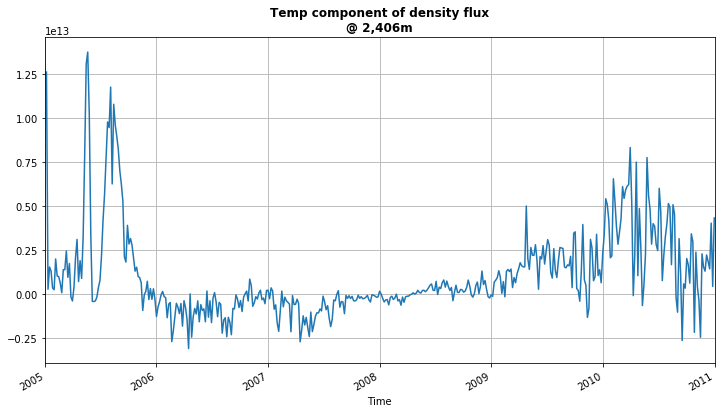

In [108]:
F_sig_heat_lower.plot(figsize=(12,6))
plt.xlim('2005', '2011')
plt.grid()
plt.xlim('2005', '2011')
plt.title('Temp component of density flux\n@ 2,406m', weight='semibold');

## Salinity component of sigma flux at 2,046m

In [112]:
sss_mean_lower = sss_lower.mean(dim='time').load()

In [113]:
surface_mask_lower = (coords.hFacC.isel(Z=27)>0).load()

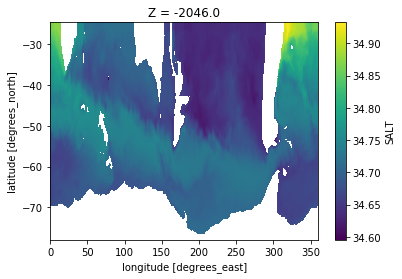

In [114]:
sss_mean_lower.where(surface_mask_lower).plot()

In [115]:
left_lon = 299
upper_lat = -66
right_lon = 360
lower_lat = -78

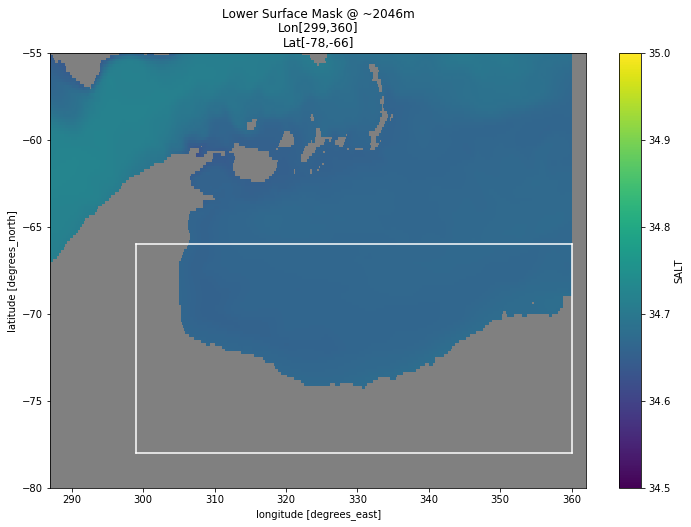

In [130]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sss_mean_lower.where(surface_mask_lower)).plot(ax=ax, vmin=34.5, vmax=35)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Lower Surface Mask @ ~2046m\nLon[299,360]\nLat[-78,-66]');

In [117]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [118]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [119]:
#advective flux
adv_flux_y_lower = ds.ADVy_SLT.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                dim=['XC','Z']).load()
adv_flux_x_lower = ds.ADVx_SLT.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                dim=['YC','Z']).load()
adv_flux_z_lower = ds.ADVr_SLT.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-119824.,  -74128.,  -92656., ..., -122416.,  -61980.,  -94804.],
      dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -66.12497
    Zl       float32 -1904.0

In [120]:
#diffusive flux
diff_flux_y_lower = ds.DFyE_SLT.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                 dim=['XC','Z']).load()
diff_flux_x_lower = ds.DFxE_SLT.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                 dim=['YC','Z']).load()
diff_flux_z_lower =  ((ds.DFrE_SLT.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + ds.DFrI_SLT.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + ds.KPPg_SLT.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                                                                                                  ).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ 3.578557e+05, -1.895548e+03, -2.549492e+03, ...,  7.791396e+01,
        3.105708e+02,  3.735557e+02], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -66.12497
    Zl       float32 -1904.0

In [121]:
totstend_weddell_lower = ((ds.TOTSTEND * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                   dim=['XC', 'YC','Z']))/ (24*60*60)
totstend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-238043.188148,   75993.167407,   95222.820741, ...,  122356.02963 ,
         61669.226667,   94413.594074])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

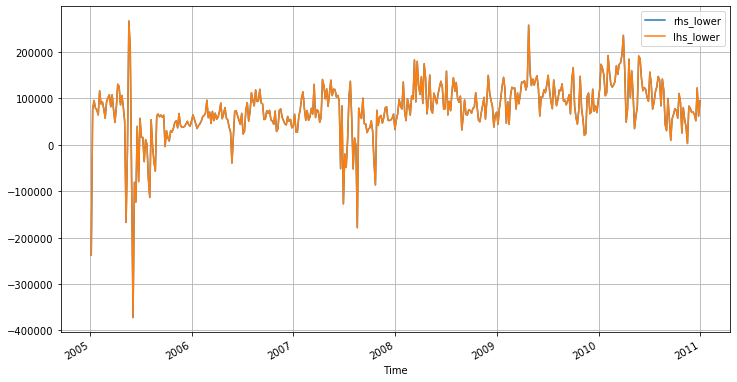

In [122]:
plt.figure(figsize=(12,6))
rhs_lower = -adv_flux_lower - diff_flux_lower
lhs_lower = totstend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();

In [123]:
beta_bottom = (beta_lower.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC']).load()
beta_bottom

<xarray.DataArray (time: 438)>
array([2.511309e+09, 2.511308e+09, 2.511308e+09, ..., 2.510940e+09,
       2.510938e+09, 2.510936e+09], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [124]:
F_sig_salt_lower = beta_bottom * rhs_lower
F_sig_salt_lower.load() #kg/m^2/s

<xarray.DataArray (time: 438)>
array([-5.977710e+14,  1.909186e+14,  2.390903e+14, ...,  3.071836e+14,
        1.548481e+14,  2.371088e+14], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 359.83334
    YG       float32 -66.12497
    Zl       float32 -1904.0

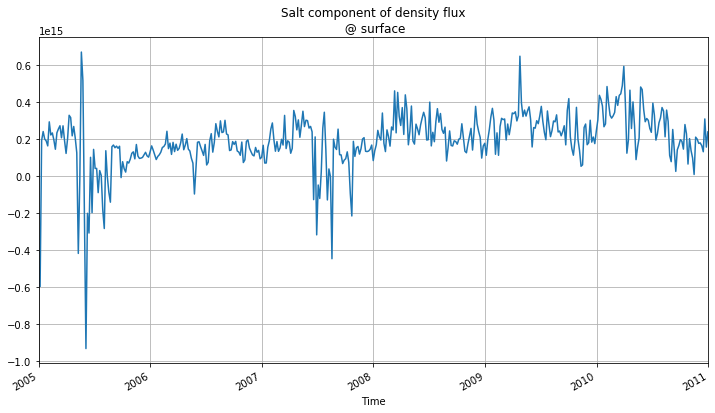

In [125]:
F_sig_salt_lower.plot(figsize=(12,6))
plt.xlim('2005', '2011')
plt.grid()
plt.title('Salt component of density flux\n @ surface');

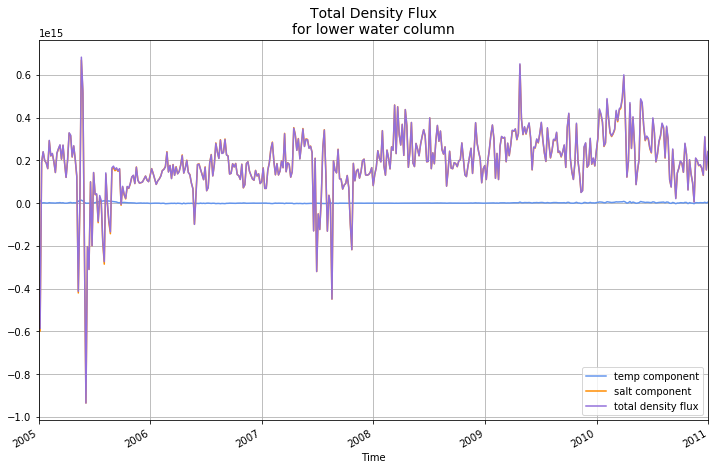

In [136]:
plt.figure(figsize=(12,7))
F_sig_heat_lower.plot(label='temp component', c='cornflowerblue')
F_sig_salt_lower.plot(label='salt component', c='darkorange')
(F_sig_heat_lower + F_sig_salt_lower).plot(label='total density flux', c='mediumpurple')
plt.xlim('2005', '2011')
#plt.ylim(-0.2e14, 0.2e14)
plt.grid()
plt.legend()
plt.title('Total Density Flux\nfor lower water column', fontsize=14, weight='medium');